In [1]:
import latentvelo as ltv
import numpy as np
import scanpy as sc
import scvelo as scv
import gc

adata = sc.read('../../../../../../../media/spencer/Seagate Backup Plus Drive/scRNAseq/gastrulation.h5ad')

# subsample data
np.random.seed(1)
adata = adata[np.random.choice(adata.shape[0], size=30000, replace=False)]

# set up experimental time
adata.obs['exp_time'] = np.array([float(t[1:]) for t in adata.obs['stage']])
adata.obs['exp_time'] = adata.obs['exp_time']/adata.obs['exp_time'].max()

adata.obs['celltype_names'] = adata.obs['celltype'].copy().values
scv.pp.filter_genes(adata, min_shared_counts=20)
gc.collect()

ltv.utils.anvi_clean_recipe(adata, batch_key='sequencing.batch', celltype_key='celltype')

gc.collect()

model = ltv.models.AnnotVAE(observed=2000, latent_dim=70, zr_dim=6, h_dim=7,
                            encoder_hidden=80,
                             celltypes=34, exp_time=True, time_reg=True,
                            time_reg_weight=0.2, time_reg_decay = 25, 
                            batch_correction=True, batches=len(adata.obs['sequencing.batch'].unique()))


epochs, val_ae, val_traj = ltv.train_anvi(model, adata, epochs=50, batch_size = 1000, name='full_gastrulation_annot', grad_clip=10, learning_rate=0.7e-2) #learning_rate=0.9e-2)

Global seed set to 0


Filtered out 44504 genes that are detected 20 counts (shared).
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:21) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Warning, folder already exists. This may overwrite a previous fit.
1197 velocity genes used
epoch 0, full loss 808.231, val loss 277.967, ae MSE 3.742, traj MSE 5.208, reg loss -3.150
epoch 1, full loss 291.292, val loss 196.935, ae MSE 3.081, traj MSE 3.210, reg loss -4.039
epoch 2, full loss 92.899, val loss 99.272, ae MSE 2.054, traj MSE 3.101, reg loss -4.092
epoch 3, full loss 1.809, val loss 6.955, ae MSE 1.817, traj MSE 2.851, reg loss -4.667
epoch 4, full loss -65.425, val loss -59.568, ae MSE 1.578, traj MSE 2.468, reg loss -3.994
epoch 5, full loss -98.134, val loss -118.053, ae MSE 1.442, traj MSE 2.322, 

In [2]:
latent_adata = ltv.output_results(model, adata)

In [3]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')

computing velocity graph (using 1/16 cores)


  0%|          | 0/30000 [00:00<?, ?cells/s]

    finished (0:00:14) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [4]:
all_colours_new = {
  "Allantois" : "#532C8A",
  "Anterior Primitive Streak" : "#c19f70",
  "Blood progenitors 1" : "#f9decf",
  "Blood progenitors 2" : "#c9a997",
  "Cardiomyocytes" :  "#B51D8D",#
  "Caudal epiblast" : "#9e6762",
  "Caudal Mesoderm" : "#3F84AA",
  "Def. endoderm" : "#F397C0",#
  "Nascent mesoderm" :  "#C594BF",#                 
  "Mixed mesoderm" :  "#DFCDE4",#
  
  "Endothelium" :  "#eda450",#                              
  "Epiblast" :  "#635547",#
  "Erythroid1" :  "#C72228",#                               
  "Erythroid2" :  "#EF4E22",#   
  "Erythroid3" : "#f77b59",
  "ExE ectoderm" :  "#989898",#                            
  
  "ExE endoderm" : "#7F6874",#                     
  "ExE mesoderm" :  "#8870ad",#
  
  
  "Rostral neurectoderm" :  "#65A83E",#
  "Forebrain/Midbrain/Hindbrain" : "#647a4f",
  
  
  "Gut" :  "#EF5A9D",#[19] "Foregut"                                     
  "Haematoendothelial progenitors" :  "#FBBE92",#            
  "Caudal neurectoderm": "#354E23",
  
  
  "Intermediate mesoderm" :  "#139992",#    
  "Neural crest": "#C3C388",
  
  "NMP" :  "#8EC792",#                                    
  "Notochord" :  "#0F4A9C",#                          
  "Paraxial mesoderm" :  "#8DB5CE",#
  "Parietal endoderm" :  "#1A1A1A",                         
  "PGC" :  "#FACB12",                                       
  
  "Pharyngeal mesoderm" :  "#C9EBFB",#                      
  "Primitive Streak" :  "#DABE99",#
  "Mesenchyme" : "#ed8f84",
  "Somitic mesoderm" :  "#005579",#                                  
  "Spinal cord" :  "#CDE088",#                     
  "Surface ectoderm" : "#BBDCA8",#                          
  
  
  "Visceral endoderm" : "#F6BFCB",#
  "Mes1": "#c4a6b2",#
  "Mes2":"#ca728c",#
  
  "Cardiomyocytes" :  "#B51D8D",
  


}

In [5]:
latent_adata.uns['celltype_names_colors'] = all_colours_new
adata.uns['celltype_names_colors'] = all_colours_new

computing velocity embedding
    finished (0:00:05) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


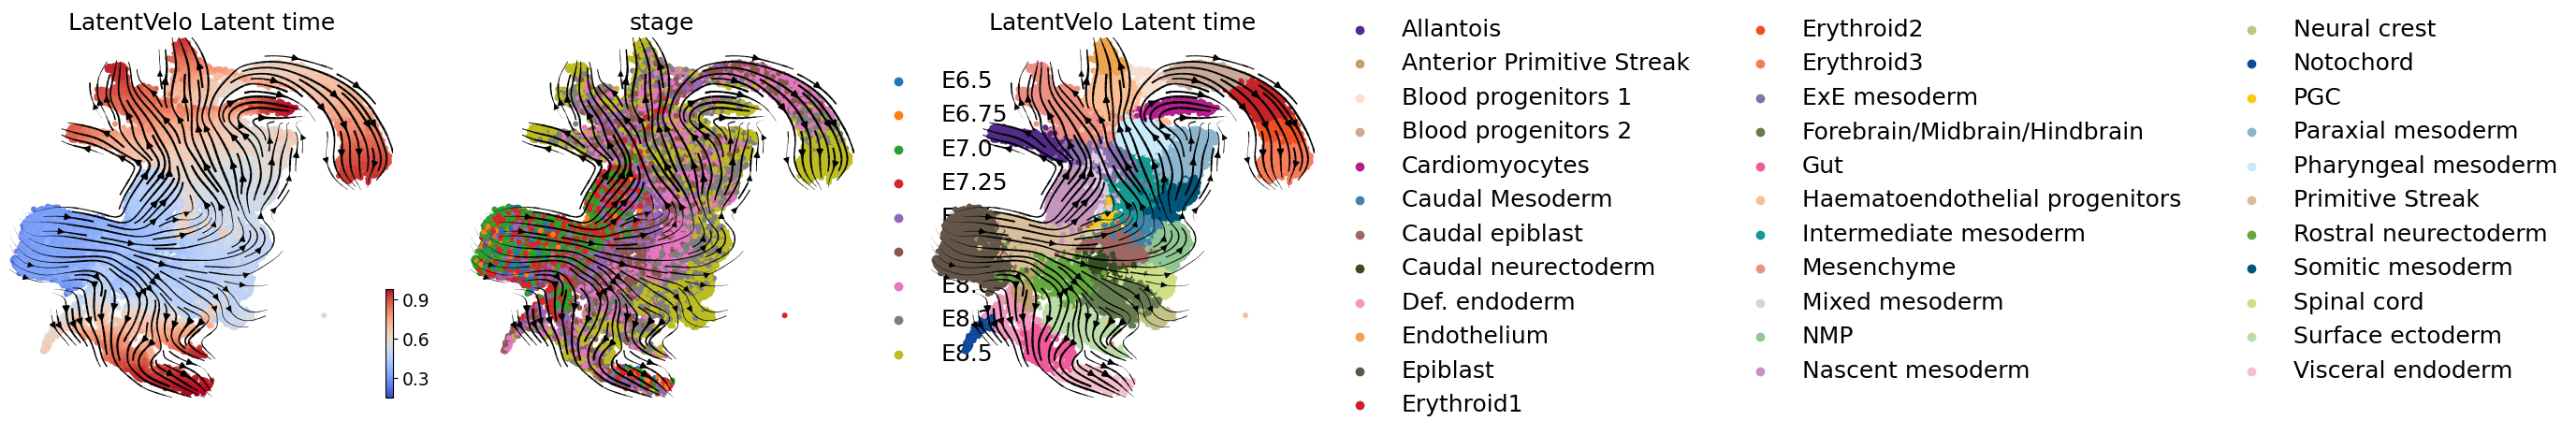

In [6]:
scv.pl.velocity_embedding_stream(latent_adata, basis='umap',vkey='spliced_velocity',
                                 color=['latent_time', 'stage','celltype_names'], color_map='coolwarm',
                                 title=['LatentVelo Latent time', 'stage'], cutoff_perc=0,
                                 alpha=1, legend_fontsize=18, legend_fontoutline=3, fontsize=18,
                                figsize=(6,5), size=75, legend_loc='right')

saving figure to file ../figures/Mouse_gastrulation_velocity.png


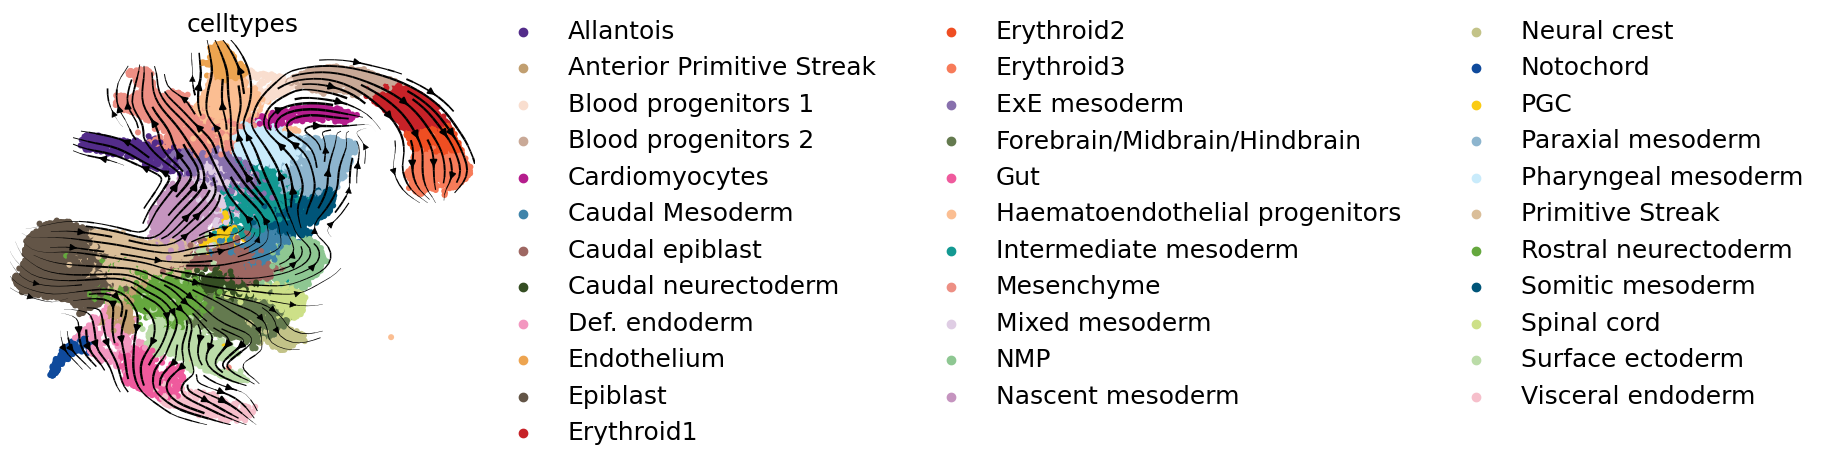

In [7]:
scv.pl.velocity_embedding_stream(latent_adata, basis='umap',vkey='spliced_velocity',
                                 color=['celltype_names'], color_map='coolwarm',
                                 title=['celltypes'], cutoff_perc=0,
                                 alpha=1, legend_fontsize=18, legend_fontoutline=3, fontsize=18,
                                figsize=(6,5), size=75, legend_loc='right', save='../figures/Mouse_gastrulation_velocity.png')

saving figure to file ../figures/gastrulation_velocity_times.png


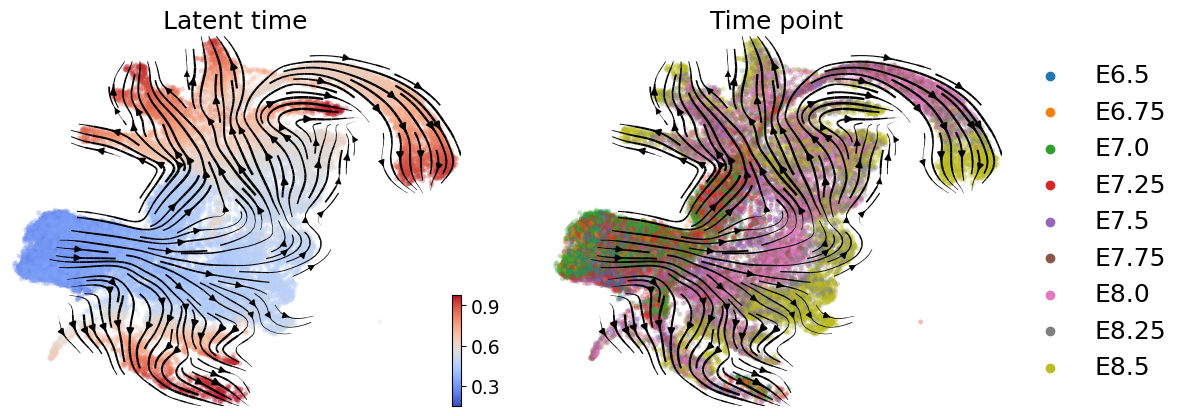

In [8]:
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', 
                                 color=['latent_time','stage'], title=['Latent time', 'Time point']
                                 , color_map='coolwarm', size=50, legend_loc='right',
                                 legend_fontsize=18, legend_fontoutline=3, fontsize=18,
                                save='../figures/gastrulation_velocity_times.png')

saving figure to file ../figures/gastrulation_zr.png


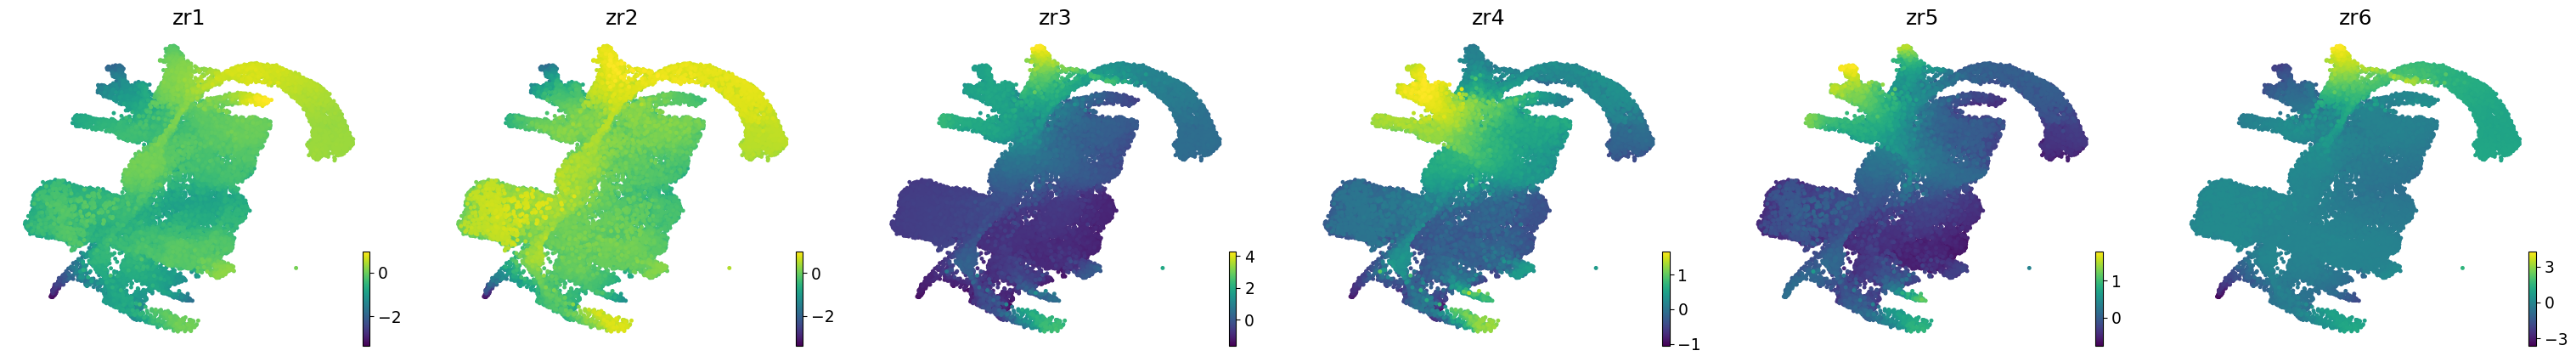

In [9]:
for i in range(latent_adata.obsm['zr'].shape[1]):
    latent_adata.obs['zr'+str(i+1)] = latent_adata.obsm['zr'][:,i].copy()
    
scv.pl.umap(latent_adata, color=['zr1','zr2','zr3','zr4', 'zr5', 'zr6'], size=50,
           save='../figures/gastrulation_zr.png', legend_fontsize=18, legend_fontoutline=3, fontsize=18)

In [10]:
remap_cat_dict = {'Primitive Streak':'Prim. Streak',
                  'Anterior Primitive Streak':'Ant. Prim. Streak',
    'Nascent mesoderm': 'Nasc. mesoderm', 
                   'Haematoendothelial progenitors': 'Haem. endothel. prog.', 
                   'Blood progenitors 1': 'Blood prog. 1', 
                'Blood progenitors 2': 'Blood prog. 2'}

latent_adata.obs['new_celltypes'] = latent_adata.obs['celltype_names'].replace(remap_cat_dict).astype('category') #.map(remap_cat_dict).astype('category')

In [11]:
import pandas as pd
def transition_scores(transition_scores_raw, model_names=None, model_label = 'Model', 
                      raw=False, custom_colors = None, height=4, aspect=1,ax=None):

    if model_names == None:

        if raw == False:
            
            print('a')
        else:
            score = []
            transition = []
            embedding=[]
            
            for key in transition_scores_raw.keys():
                for item in transition_scores_raw[key]:
                    score.append(item)
                    transition.append(key[0] + r'$\rightarrow$' + key[1])
            
            transition_scores_ = pd.DataFrame({'CBDir score':score, ' ':transition})
            
            PROPS = {
            'boxprops':{'facecolor':'darkgrey', 'edgecolor':'black'},
            'medianprops':{'color':'black'},
            'whiskerprops':{'color':'black'},
                'capprops':{'color':'black'}
            }
            
            ax = sns.boxplot(
                data=transition_scores_, 
                y=' ', x="CBDir score", 
                orient='h', fliersize=0, **PROPS, showmeans=True,ax=ax,
                            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"8"}
            )

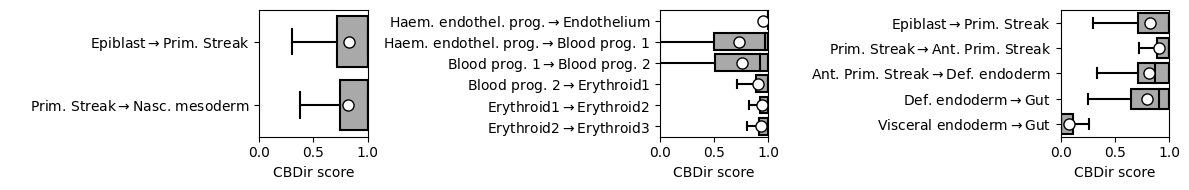

In [12]:
mesoderm_edges = [('Epiblast', 'Prim. Streak'),
                 ('Prim. Streak', 'Nasc. mesoderm')]

latent_adata.obsm['X_latent'] = latent_adata.X.copy()
latent_adata.obsm['velocity_latent'] = latent_adata.layers['spliced_velocity'].copy()

mesoderm_scores = ltv.ev.cross_boundary_correctness(latent_adata, 'new_celltypes', 'velocity_latent', mesoderm_edges,
                                  x_emb='X_latent', majority_vote=True, return_raw=True)

blood_edges = [
                 ('Haem. endothel. prog.', 'Endothelium'),
              ('Haem. endothel. prog.', 'Blood prog. 1'),
              ('Blood prog. 1', 'Blood prog. 2'),
              ('Blood prog. 2', 'Erythroid1'),
              ('Erythroid1', 'Erythroid2'),
              ('Erythroid2', 'Erythroid3')]

latent_adata.obsm['X_latent'] = latent_adata.X.copy()
latent_adata.obsm['velocity_latent'] = latent_adata.layers['spliced_velocity'].copy()

blood_scores = ltv.ev.cross_boundary_correctness(latent_adata, 'new_celltypes', 'velocity_latent', blood_edges,
                                  x_emb='X_latent', majority_vote=True, return_raw=True)

gut_edges = [('Epiblast', 'Prim. Streak'), 
            ('Prim. Streak', 'Ant. Prim. Streak'),
             ('Ant. Prim. Streak', 'Def. endoderm'),
    ('Def. endoderm', 'Gut') ,('Visceral endoderm', 'Gut')]

latent_adata.obsm['X_latent'] = latent_adata.X.copy()
latent_adata.obsm['velocity_latent'] = latent_adata.layers['spliced_velocity'].copy()

gut_scores = ltv.ev.cross_boundary_correctness(latent_adata, 'new_celltypes', 'velocity_latent', gut_edges,
                                  x_emb='X_latent', majority_vote=True, return_raw=True)


import matplotlib.pyplot as plt
import seaborn as sns

fig,ax=plt.subplots(1,3,figsize=(12,2))

transition_scores(mesoderm_scores, raw=True,ax=ax[0])
ax[0].set(xlim=(0.,1))
ax[0].tick_params(axis='y')

transition_scores(blood_scores, raw=True,ax=ax[1])
ax[1].set(xlim=(0.,1))
ax[1].tick_params(axis='y')

transition_scores(gut_scores, raw=True,ax=ax[2])
ax[2].set(xlim=(0.,1))
ax[2].tick_params(axis='y')

fig.tight_layout()
fig.subplots_adjust(wspace=2.7)
fig.savefig('../figures/gastrulation_transition_scores.pdf')
fig.show()
plt.show()

In [13]:
# free up some space
del adata.layers['Mu']
del adata.layers['Ms']
del adata.layers['spliced_counts']
del adata.layers['unspliced_counts']
del adata.layers['mask_spliced']
del adata.layers['mask_unspliced']

gc.collect()

57358

In [14]:
z_traj, times = ltv.cell_trajectories(model, adata)

In [15]:
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap

pca = PCA(n_components=6).fit(latent_adata.X)
umap = UMAP(n_components=2, min_dist=0.5, n_neighbors=100).fit(pca.transform(latent_adata.X))

transformed = umap.transform(pca.transform(latent_adata.X))
latent_adata.obsm['X_umap_latent'] = transformed
scv.pp.neighbors(latent_adata, use_rep='X', n_neighbors=30)
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')

computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/16 cores)


  0%|          | 0/30000 [00:00<?, ?cells/s]

    finished (0:00:12) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:05) --> added
    'spliced_velocity_umap_latent', embedded velocity vectors (adata.obsm)
saving figure to file ../figures/mouse_gastrulation_latent_umap.png


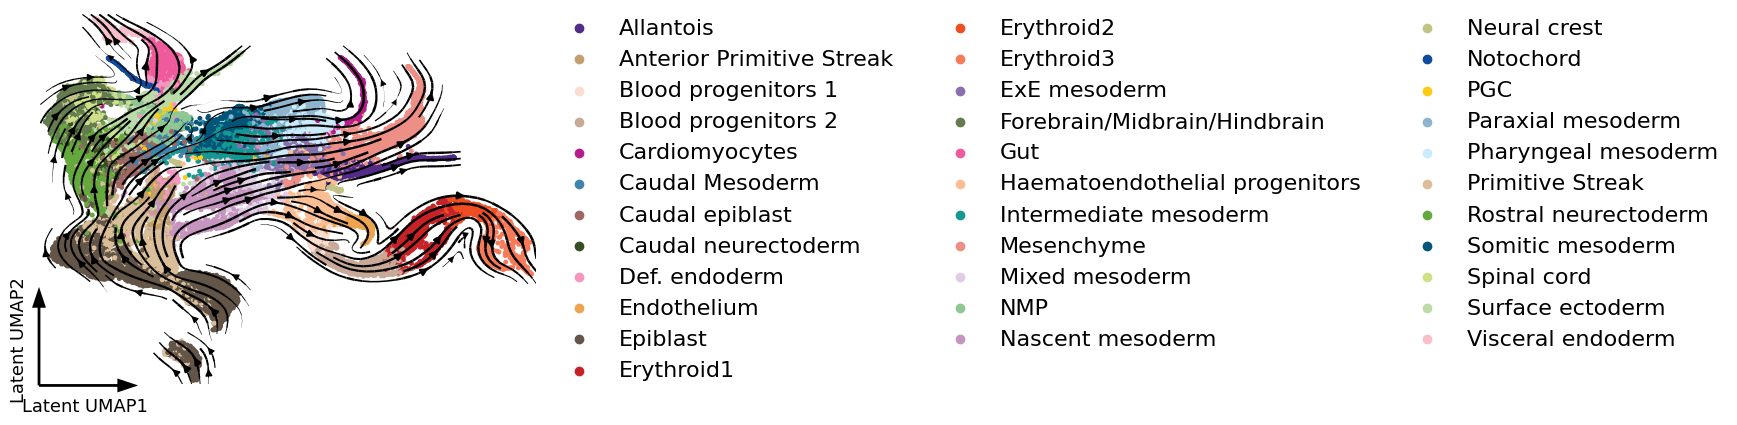

In [16]:
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', 
                                 basis='umap_latent', color=['celltype_names'], alpha=1, size=50,
                                frameon='artist', legend_loc='right',cutoff_perc=0,
                                xlabel = 'Latent UMAP1', ylabel='Latent UMAP2', title='', legend_fontsize=16,
                                fontsize=15.5,
                                save='../figures/mouse_gastrulation_latent_umap.png')

# Trajectories

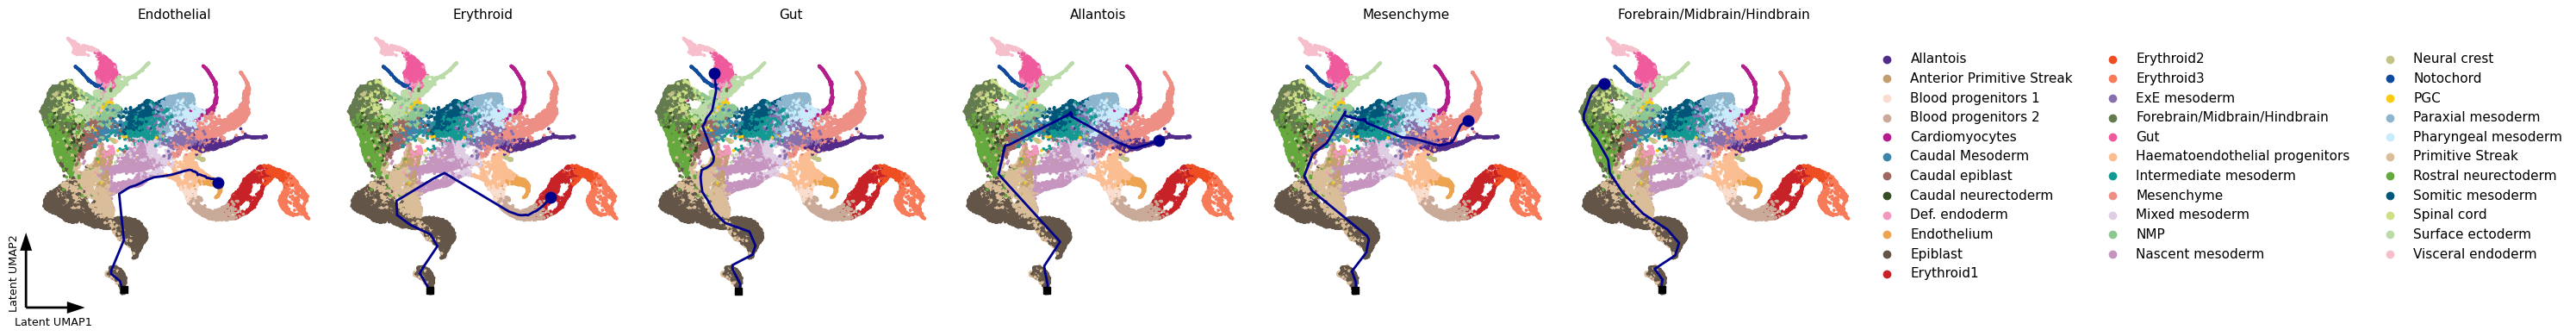

In [17]:
cells = [123, 84, 1, 44, 14, 30]

from sklearn.inspection import DecisionBoundaryDisplay
color = '#00008B'

import matplotlib.colors
cmap = matplotlib.colors.ListedColormap(['#1f78b4', '#b2df8a', '#6a3d9a', '#cab2d6'])


fig,ax=plt.subplots(1, 6, figsize=(30,4))
ax=ax.flatten()


color = '#00008B'

latent_adata.obsm['X_umap'] = latent_adata.obsm['X_umap_latent']

z_traj_pca = umap.transform(pca.transform(z_traj[cells[0],times[cells[0],:,0]<=latent_adata.obs['latent_time'][cells[0]],:70].detach().cpu().numpy()))
ax[0].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[0].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)
ax[0].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)

scv.pl.umap(latent_adata, ax=ax[0], color='celltype_names', frameon='artist',
           xlabel='Latent UMAP1', ylabel='Latent UMAP2', show=False, fontsize=11, title='Endothelial', legend_loc='none',size=30)


z_traj_pca = umap.transform(pca.transform(z_traj[cells[1],times[cells[1],:,0]<=latent_adata.obs['latent_time'][cells[1]],:70].detach().cpu().numpy()))
ax[1].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[1].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)
ax[1].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)

scv.pl.umap(latent_adata, ax=ax[1], color='celltype_names',
           xlabel='Latent UMAP1', ylabel='Latent UMAP2', show=False, fontsize=11, title='Erythroid', legend_loc='none',size=30)


z_traj_pca = umap.transform(pca.transform(z_traj[cells[2],times[cells[2],:,0]<=latent_adata.obs['latent_time'][cells[2]],:70].detach().cpu().numpy()))
ax[2].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[2].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)
ax[2].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)

scv.pl.umap(latent_adata, ax=ax[2], color='celltype_names',
           xlabel='Latent UMAP1', ylabel='Latent UMAP2', fontsize=11, show=False, title='Gut', legend_loc='none',size=30)


z_traj_pca = umap.transform(pca.transform(z_traj[cells[3],times[cells[3],:,0]<=latent_adata.obs['latent_time'][cells[3]],:70].detach().cpu().numpy()))
ax[3].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[3].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)
ax[3].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)

scv.pl.umap(latent_adata, ax=ax[3], color='celltype_names',
           xlabel='Latent UMAP1', ylabel='Latent UMAP2', show=False, fontsize=11, title='Allantois', legend_loc='none',size=30)



z_traj_pca = umap.transform(pca.transform(z_traj[cells[4],times[cells[4],:,0]<=latent_adata.obs['latent_time'][cells[4]],:70].detach().cpu().numpy()))
ax[4].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[4].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)
ax[4].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)

scv.pl.umap(latent_adata, ax=ax[4], color='celltype_names',
           xlabel='Latent UMAP1', ylabel='Latent UMAP2', show=False, fontsize=11, title='Mesenchyme', legend_loc='none',size=30)


z_traj_pca = umap.transform(pca.transform(z_traj[cells[5],times[cells[5],:,0]<=latent_adata.obs['latent_time'][cells[5]],:70].detach().cpu().numpy()))
ax[5].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[5].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)
ax[5].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)

scv.pl.umap(latent_adata, ax=ax[5], color='celltype_names',
           xlabel='Latent UMAP1', ylabel='Latent UMAP2', show=False, fontsize=11, title='Forebrain/Midbrain/Hindbrain', 
            legend_loc='right', legend_fontsize=11,size=30)

plt.tight_layout()
plt.savefig('../figures/Mouse_gastrulation_trajectories.png', dpi=500)
plt.show()